In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from pylab import rcParams

Данные взяты с https://www.kaggle.com/dronio/SolarEnergy/downloads/solar-radiation-prediction.zip/1

In [2]:
df = pd.read_csv('SolarPrediction.csv')
print(df.shape)

(32686, 11)


In [3]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Данные содержат измерения некоторых атмосферных показателей за 4х месячный период. Измерения производились в среднем раз в 5 минут. Фиксировались такие показатели как:

Pressure - давление

Temperature - температура

Speed - скорость ветра

WindDirection(Degrees) - направление ветра

Radiation - уровень солнечной радиации

TimeSunRise - время восхода

TimeSunSet - время заката

**Задача**: провести анализ данных и предсказать уровень солнечной радиации.

In [4]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [5]:
df.isnull().values.any()

False

In [6]:
df.duplicated().any()

False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


Можно заметить, что данные подготовлены хорошо - нет nan-ов, дубликатов и выбросов. Судя по всему, товарищи из NASA заботливо всё сделали за меня, поскольку в таблице есть записи, между которыми не 5 минут разницы, f 10/15/20 что похоже на выброшенные значения.

Единственное, что тут можно сделать с данными - уменьшить объём занимаемой памяти. Точность float64 нам не нужна, как и int64, судя по максимальным значениям.

In [8]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = df[col].astype('float32')
    elif df[col].dtype == 'int64':
        df[col] = df[col].astype('int32')

Теперь представим данные в хронологическом порядке через колонки Date и Time для удобства дальнейшего использования. Тогда колонка UNIXTime нам не нужна.

In [9]:
df = df.drop('UNIXTime', axis=1)

In [10]:
from datetime import datetime


def convert_colums_date_and_time_to_strptime(df):
    x = []
    for d, t in zip(df['Data'], df['Time']):
        date = d.split(' ', 1)[0] + ' ' + t
        x.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    df = df.drop(['Data', 'Time'], axis=1)
    df['Date_Time'] = x
    return df

df = convert_colums_date_and_time_to_strptime(df).set_index('Date_Time').sort_index()

In [11]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
Date_Time,,,,,,,,
2016-09-01 00:00:08,2.58,51,30.43,103,77.269997,11.25,06:07:00,18:38:00
2016-09-01 00:05:10,2.83,51,30.43,103,153.440002,9.00,06:07:00,18:38:00
2016-09-01 00:20:06,2.16,51,30.43,103,142.039993,7.87,06:07:00,18:38:00
2016-09-01 00:25:05,2.21,51,30.43,103,144.119995,18.00,06:07:00,18:38:00
2016-09-01 00:30:09,2.25,51,30.43,103,67.419998,11.25,06:07:00,18:38:00


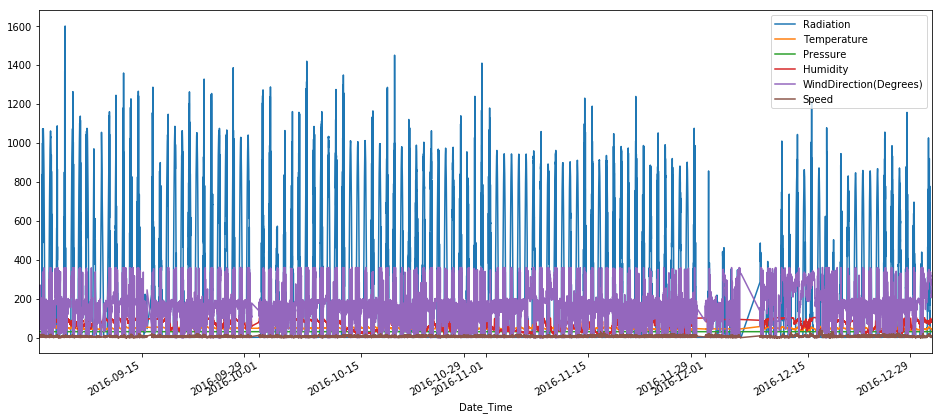

In [12]:
df.plot(figsize=(16, 7))

По графику видно, что в некоторые дни измерения отсутствуют

In [13]:
df[(df.index < datetime(2016, 10, 1)) & (df.index > datetime(2016, 9, 30))]

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
Date_Time,,,,,,,,


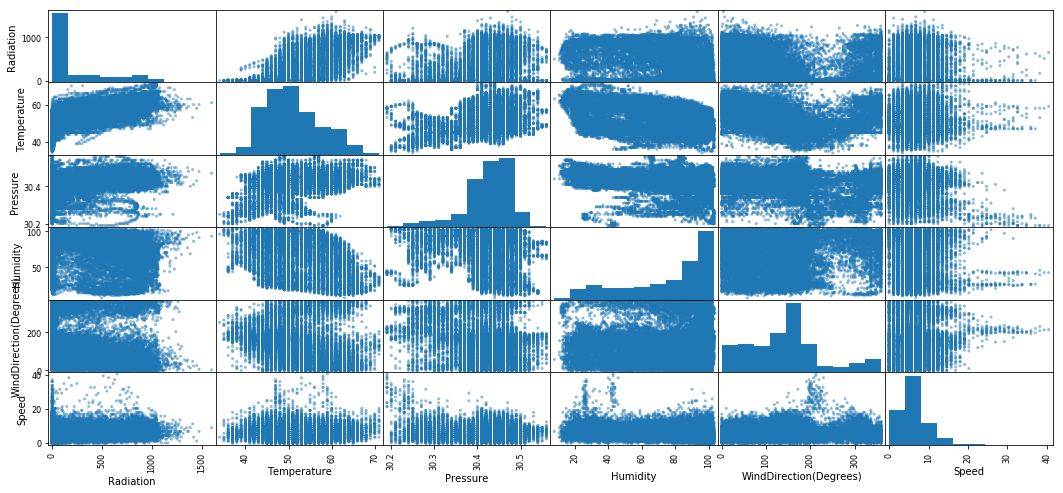

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, figsize=(18, 8))
plt.show()

In [15]:
df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000


Можно заметить сильную зависимость между Temperature и Radiation

С помощью теста Фуллера проверим, являются ли ряды стационарными, порог устанавливаем в 5%

In [16]:
def test_stationarity(timeseries, cutoff = 0.05, title = 'original', window = 12):
    
#     timeseries.plot(figsize=(15, 6), color='blue', title=title)
    rolmean = timeseries.rolling(window).mean()
#     timeseries.resample('8H').mean().plot(figsize=(15, 6), color='red', title='mean')
    
#     plt.show()
    fig = plt.figure(figsize=(18, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [17]:
cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'Speed']

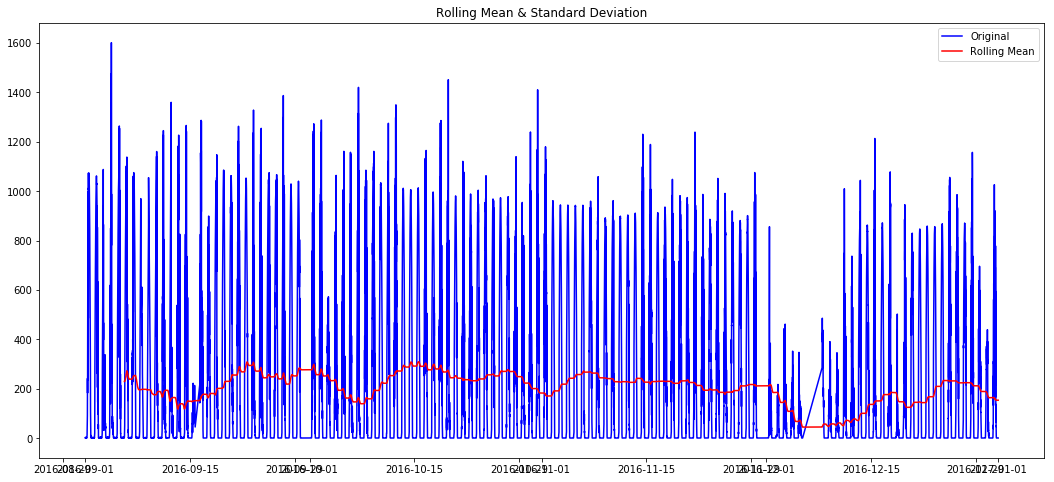

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -23.773592
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    32640.000000
Critical Value (1%)               -3.430550
Critical Value (5%)               -2.861629
Critical Value (10%)              -2.566817
dtype: float64


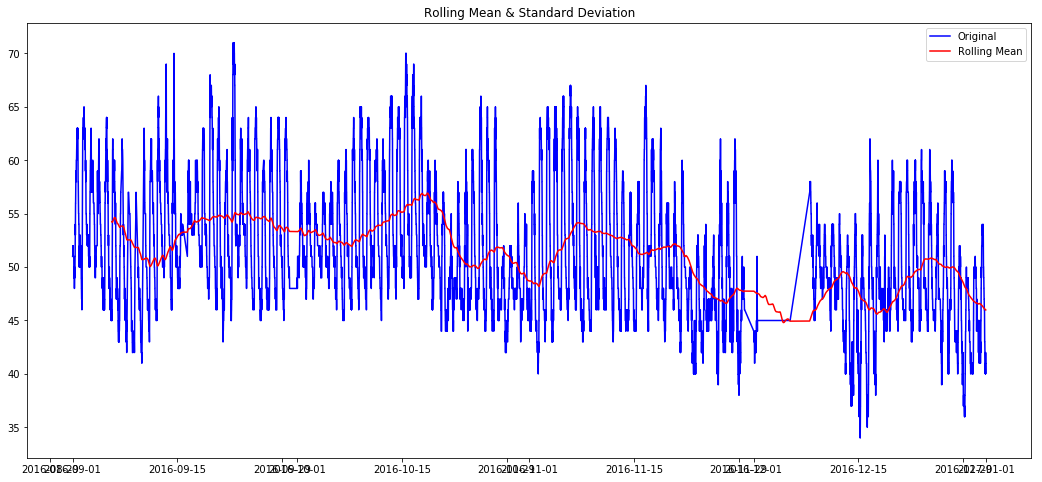

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.732560e+01
p-value                        5.448544e-30
#Lags Used                     4.500000e+01
Number of Observations Used    3.264000e+04
Critical Value (1%)           -3.430550e+00
Critical Value (5%)           -2.861629e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


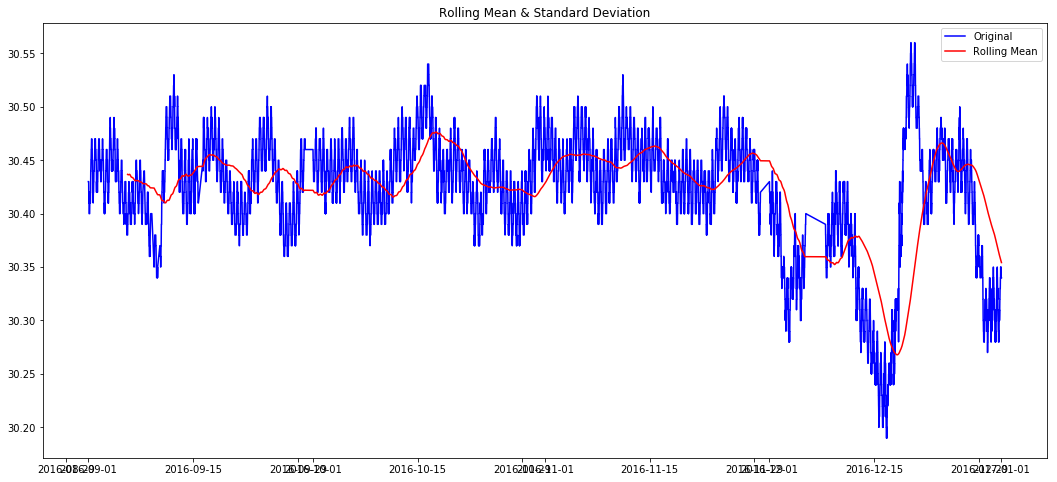

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                    -5.542612
p-value                            0.000002
#Lags Used                        52.000000
Number of Observations Used    32633.000000
Critical Value (1%)               -3.430550
Critical Value (5%)               -2.861629
Critical Value (10%)              -2.566817
dtype: float64


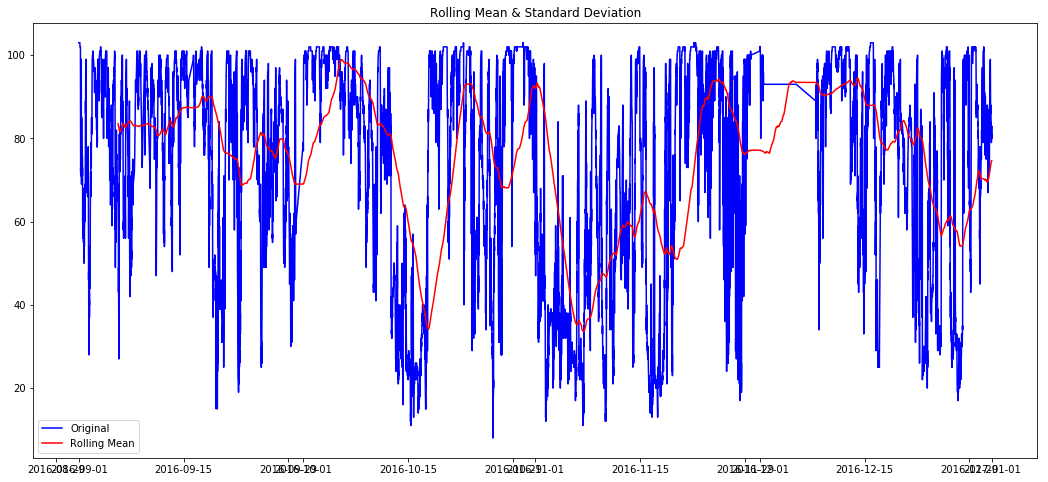

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.307469e+00
p-value                        1.071127e-15
#Lags Used                     3.600000e+01
Number of Observations Used    3.264900e+04
Critical Value (1%)           -3.430550e+00
Critical Value (5%)           -2.861629e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


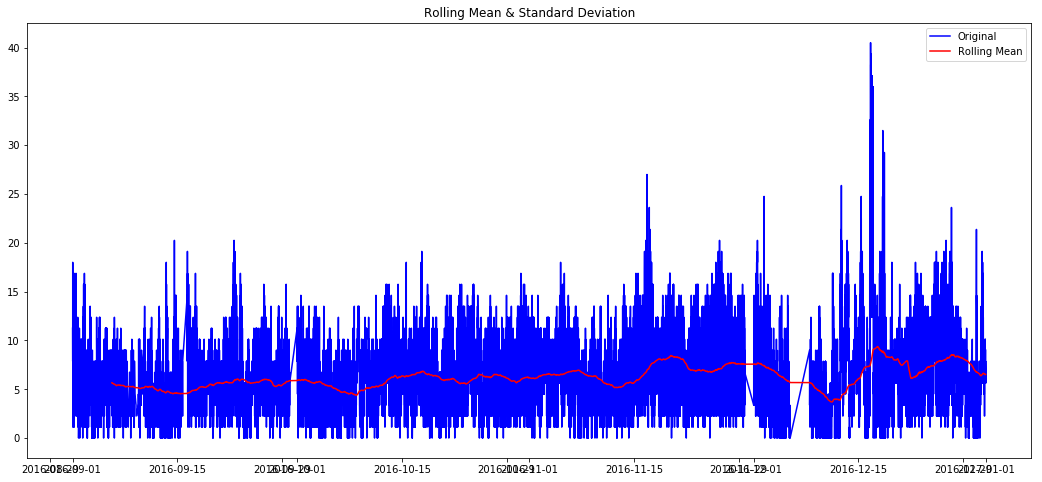

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.540366e+01
p-value                        3.190630e-28
#Lags Used                     3.300000e+01
Number of Observations Used    3.265200e+04
Critical Value (1%)           -3.430550e+00
Critical Value (5%)           -2.861629e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


In [18]:
for i in cols:
    test_stationarity(df[i], title=str(i), window=5*12*24)
#     pd.DataFrame(df[i]).plot(figsize=(15, 6), title='original')
#     x1 = pd.DataFrame(df[i]).resample('8H').mean().plot(figsize=(15, 6), title='8H')
#     x1 = pd.DataFrame(df[i]).resample('D').mean().plot(figsize=(15, 6), title='D')

# Проверка гипотез

Проверим, отличается ли среднее значение радиации в сентябре и декабре.

Основная гипотеза: средний объём радиации в сентябре незначительно отличается от среднего объёма радиации в декабре

Альтернативная гипотеза: разница между средними значениями радиации в сентябре и декабре статистически важна

In [19]:
sept = pd.DataFrame(df[df.index < datetime(2016, 10, 1)]['Radiation'])
mask = (df.index > datetime(2016, 12, 1)) & (df.index < datetime(2016, 12, 31))
dec =  pd.DataFrame(df[mask]['Radiation'])

Для проверки гипотезы с помощью параметрического критерия Стьюдента данные должны быть распределены нормально.

C помощью Shapiro–Wilk test проверим данные на нормальность. Он выдаёт адекватные значения p-value в случае выборки размером не более 5000, поэтому были взять случайным образом по 1000 представителей каждой выборки.

In [20]:
print("Sept: ", stats.shapiro(sept.sample(1000)))
print("Dec: ", stats.shapiro(dec.sample(1000)))

Sept:  (0.6831372976303101, 1.2833049297332745e-39)
Dec:  (0.6389404535293579, 1.7094439966298443e-41)


Гипотеза о нормальности выборок подтверждается, применяем критерий Стьюдента

In [21]:
stats.ttest_ind(sept, dec)

Ttest_indResult(statistic=array([18.340387], dtype=float32), pvalue=array([2.46594891e-74]))

По значению p-value гипотеза о идентичности средних с большой вероятностью отвергается

Изначально я считал, что выборки имеют не нормальное распределение, посмотрев только на q-q plot. Поэтому был применён непараметрический критерий Колмагорова-Смирнова для проверки гипотезы.

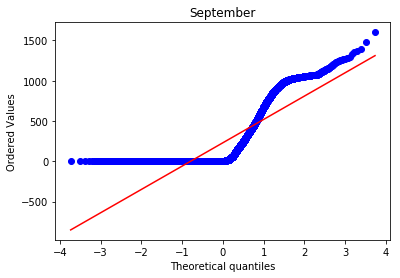

In [22]:
stats.probplot(sept.values.squeeze(), dist = "norm", plot = plt)
plt.title('September')
plt.show()

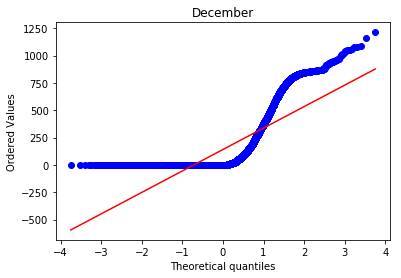

In [23]:
stats.probplot(dec.values.squeeze(), dist = "norm", plot = plt)
plt.title('December')
plt.show()

In [24]:
stats.ks_2samp(sept.values.squeeze(), dec.values.squeeze())

Ks_2sampResult(statistic=0.2683940637656358, pvalue=2.2714742144496964e-240)

Видим, что гипотеза о идентичности двух распределений с большой вероятностью отвергается, что ещё раз подтверждает статистическую значимость между средними выборок.

# Исследование временного ряда

Поскольку в этом датасете временные ряды сразу стационарны, то я выбрал другой датасет.

https://www.kaggle.com/government-of-france/crimes-in-france

In [25]:
data=pd.read_csv("crime-in-france.csv")
data.shape

(107, 214)

In [26]:
data.head()

,Index,Libellé index,2017_08,2017_07,2017_06,2017_05,2017_04,2017_03,2017_02,2017_01,...,2000_10,2000_09,2000_08,2000_07,2000_06,2000_05,2000_04,2000_03,2000_02,2000_01
0,1,Règlements de compte entre malfaireurs,8,9,8,8,2,14,15,10,...,8,8,6,5,12,5,2,9,5,11
1,2,Homicides pour voler et à l'occasion de vols,3,2,4,4,6,2,4,6,...,3,4,9,5,4,4,7,6,5,2
2,3,Homicides pour d'autres motifs,67,75,55,52,76,56,51,61,...,84,82,74,75,62,77,76,70,96,60
3,4,Tentatives d'homicides pour voler et à l'occas...,6,5,6,12,4,13,5,24,...,14,5,8,10,14,14,5,9,10,7
4,5,Tentatives homicides pour d'autres motifs,218,238,224,200,208,228,168,165,...,87,95,68,101,85,106,63,104,91,65


In [27]:
from translate import Translator
translator= Translator(from_lang="french",to_lang="russian")

In [28]:
for i, j in enumerate(data['Libellé index']):
    print(i, translator.translate(j))

0 Урегулирование счетов между злоумышленниками
1 Убийства воровать и по случаю грабежей
2 Убийства по другим причинам
3 Убийство пытается украсть и в связи с грабежами
4 Попытки убийства по другим причинам
5 Преднамеренные травмы и травмы, сопровождаемые смертью
6 Другие умышленные уголовные или исправительные травмы
7 Взятие заложников по случаю полетов
8 Взятие заложников для другой цели
9 секвестры
10 Угрозы или шантаж за вымогательство
11 Угрозы или шантаж для других целей
12 Посягает на достоинство и личность
13 Нарушения места жительства
14 Вооруженное ограбление против финансовых учреждений
15 Вооруженное ограбление против промышленных или коммерческих объектов
16 Вооруженные ограбления против компаний CIT
17 Вооруженное ограбление лиц в их домах
18 Другие вооруженные ограбления
19 Ограбление полетов против финансовых, коммерческих или промышленных учреждений
20 Вооруженное ограбление дома против лиц
21 Другие полеты с ножами
22 Насильственные безоружные полеты против финансовых

Будем исследовать зависимость количества убийств по любой причине с течением времени (строки 1-4)

In [29]:
df = pd.DataFrame({'Total_kills' : data[1:5].sum()[2:]}).sort_index()
df.head()

,Total_kills
2000_01,134
2000_02,202
2000_03,189
2000_04,151
2000_05,201


In [30]:
df.index = pd.to_datetime(df.index, format='%Y_%m')

In [31]:
df['Total_kills'] = df['Total_kills'].astype('int32')
# какой-то косяк с seasonal_decompose, нужен тип int32

Проверяем ряд на стационарность

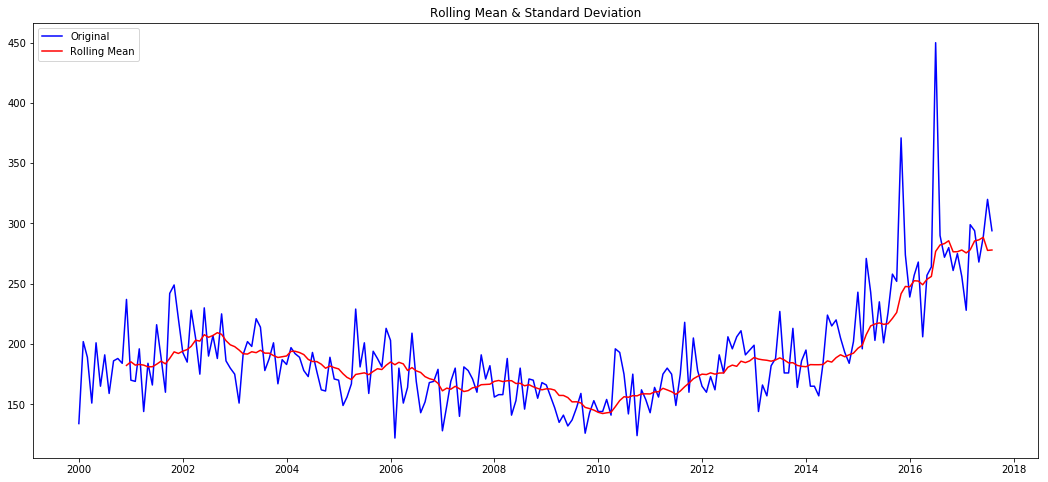

Results of Dickey-Fuller Test:
p-value = 0.9759. The series is likely non-stationary.
Test Statistic                   0.269728
p-value                          0.975912
#Lags Used                       7.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


In [32]:
test_stationarity(df.Total_kills, title='Total_kills')

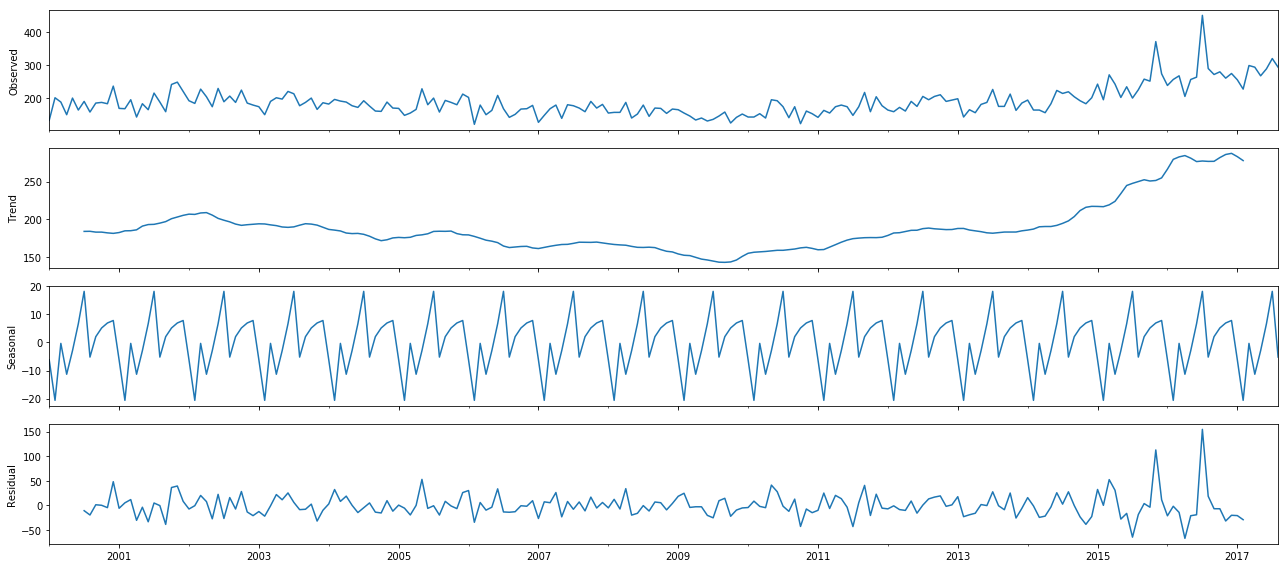

In [33]:
rcParams['figure.figsize'] = 18, 8
sm.tsa.seasonal_decompose(df.Total_kills).plot()
plt.show()

Наблюдаем сезонность с периодом в 1 год

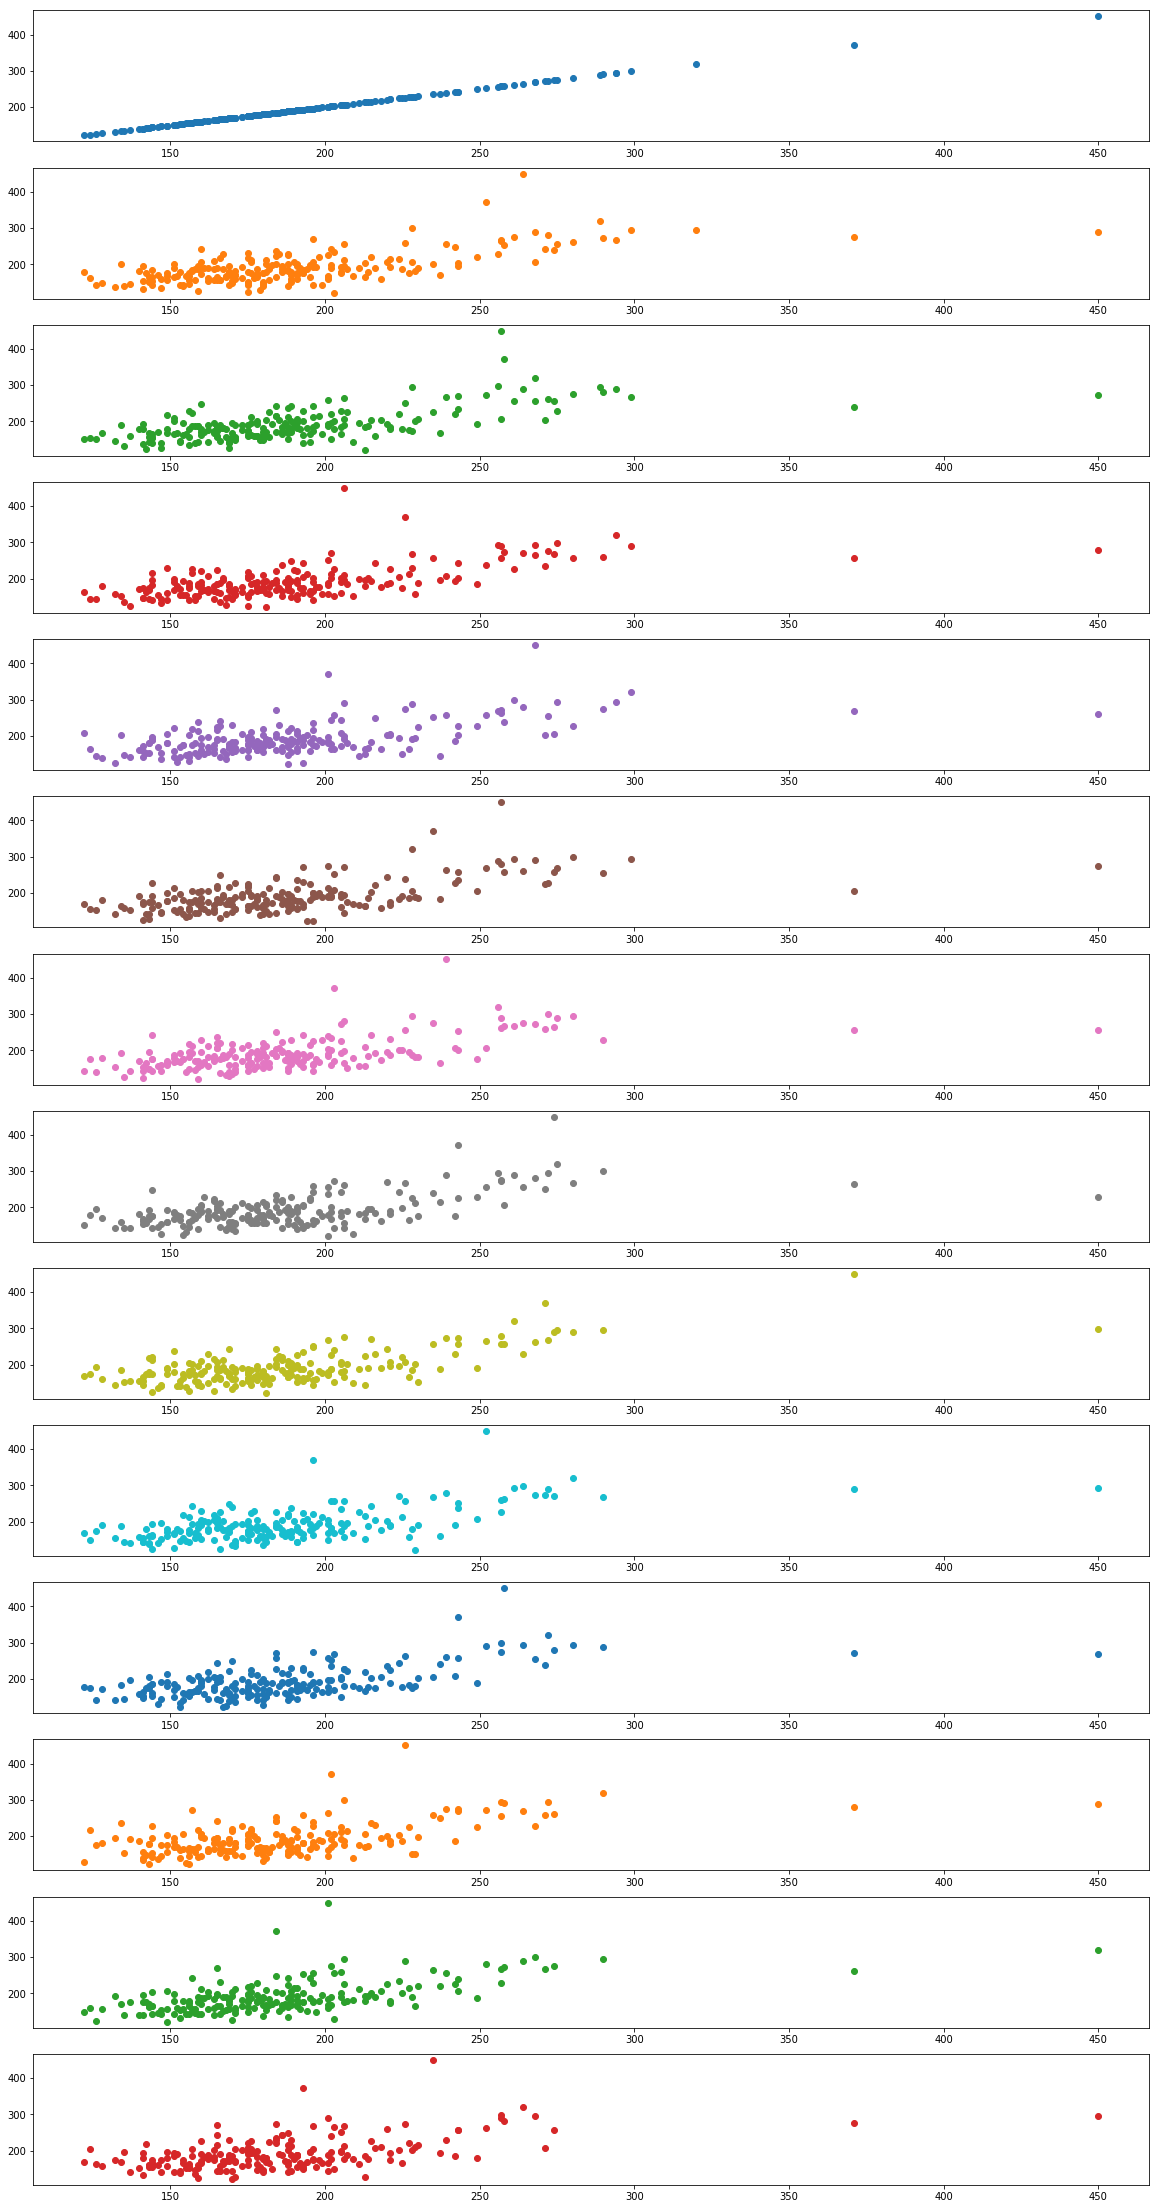

In [34]:
fig, axes = plt.subplots(14, 1, figsize = (20, 40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(df.Total_kills, df.Total_kills.shift(-k), 'o')
plt.show()

Пока наш ряд не стационарный. Исправим это чтобы применить статистическую модель

Избавляемся от тренда

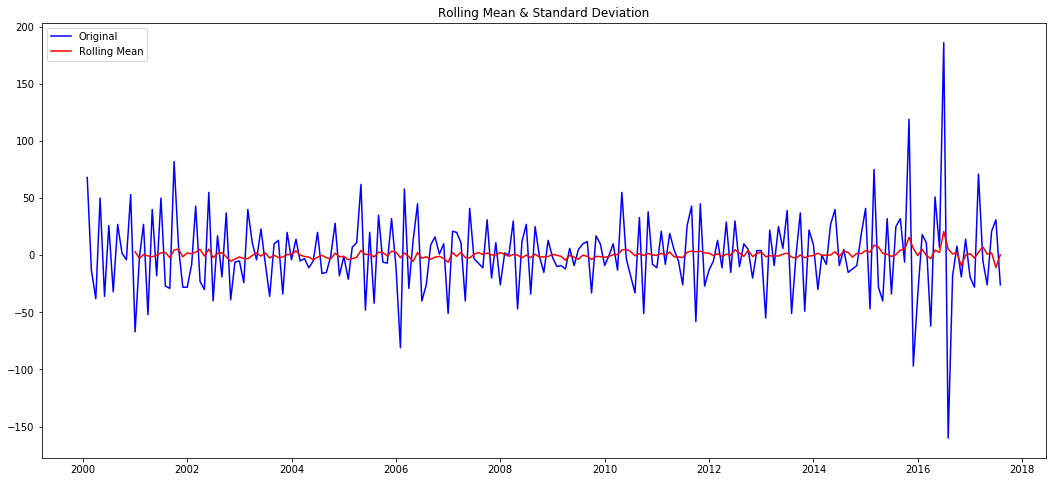

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.107954e+01
p-value                        4.346142e-20
#Lags Used                     6.000000e+00
Number of Observations Used    2.040000e+02
Critical Value (1%)           -3.462818e+00
Critical Value (5%)           -2.875815e+00
Critical Value (10%)          -2.574379e+00
dtype: float64


In [35]:
rcParams['figure.figsize'] = 12, 7
df['diff'] = df.Total_kills - df.Total_kills.shift(1)
df.dropna(inplace = True)
test_stationarity(df['diff'])

Некоторые параметры модели d = 1, D = 0

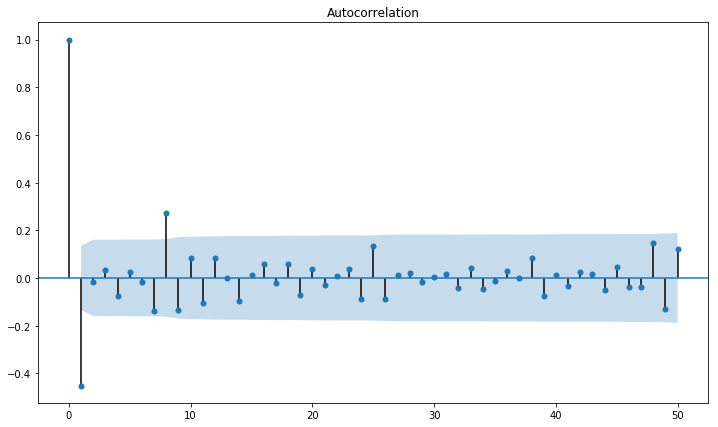

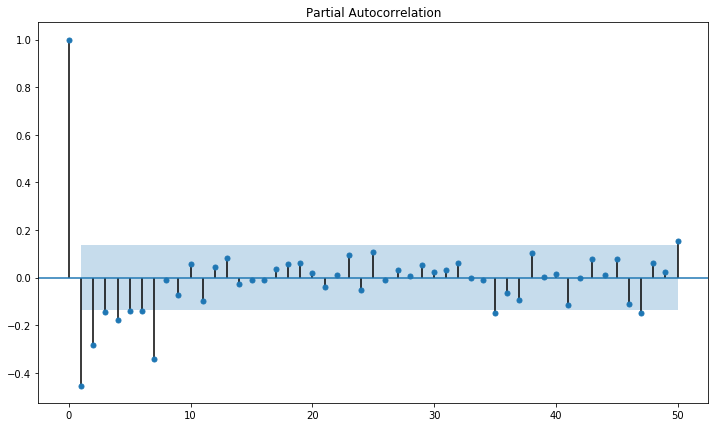

In [36]:
import statsmodels.api as sm
f_acf = sm.graphics.tsa.plot_acf(df['diff'], lags=50)
f_pacf = sm.graphics.tsa.plot_pacf(df['diff'], lags=50)
plt.show()

Построение прогноза

Кажется, p = 7 q = 8

In [37]:
d = 1
D = 0
s = 12

ps = range(6, 10)
qs = range(0, 9)
Ps = range(0, 1)
Qs = range(0, 1)

In [38]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [39]:
df = df.drop('diff', axis=1)

In [40]:
split_date = '2017-01-01'
train, test = df[:split_date], df[split_date:]
print(len(train), len(test))

204 8


In [41]:
import warnings


results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.Total_kills, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (6, 3, 0, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (8, 4, 0, 0)
wrong parameters: (8, 5, 0, 0)
wrong parameters: (9, 4, 0, 0)
wrong parameters: (9, 5, 0, 0)
wrong parameters: (9, 6, 0, 0)


In [42]:
best_param
# ну хоть с p угадал

(7, 0, 0, 0)

In [43]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:            Total_kills   No. Observations:                  204
Model:               SARIMAX(7, 1, 0)   Log Likelihood                -955.792
Date:                Sun, 19 May 2019   AIC                           1927.584
Time:                        04:32:41   BIC                           1954.090
Sample:                    02-01-2000   HQIC                          1938.307
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7644      0.085     -8.952      0.000      -0.932      -0.597
ar.L2         -0.6028      0.108     -5.584      0.000      -0.814      -0.391
ar.L3         -0.5174      0.102     -5.078      0.0

Остатки модели должны быть белым шумом

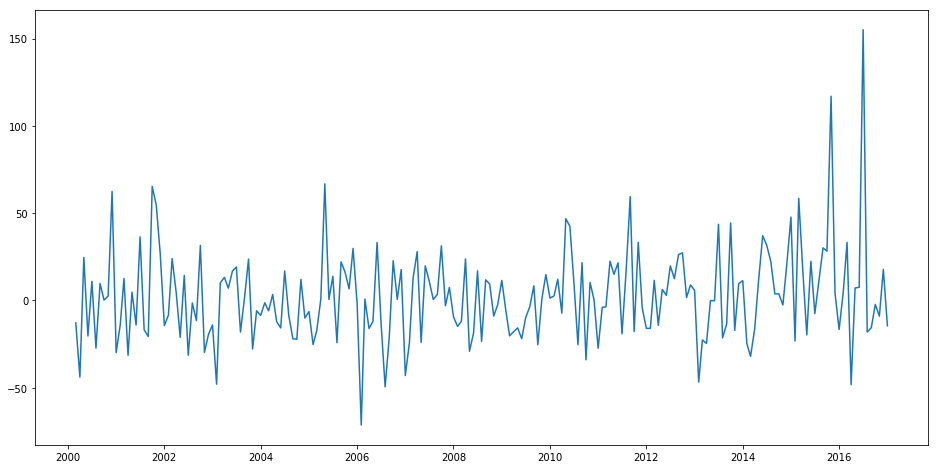

In [44]:
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

In [45]:
best_model_temp = best_model
stat_test = sm.tsa.adfuller(best_model_temp.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -16.25151652315982
p-value:  3.641526799110383e-29
Critical values:  {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515}
единичных корней нет, ряд стационарен


In [46]:
predicted_size = 12

In [47]:
forecast = best_model.predict(start = len(train), end = len(train) + len(test) + predicted_size)

C:\Program Files (x86)\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


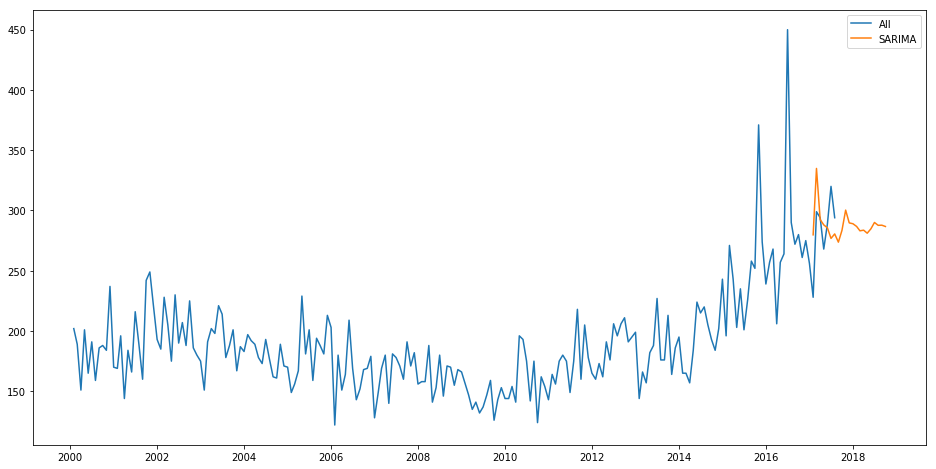

In [48]:
plt.figure(figsize=(16,8))
plt.plot(df.Total_kills, label='All')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

И по графику видно, что предсказания получились не очень, но ради приличия посчитаем ещё среднеквадратичную ошибку

In [49]:
np.std(np.array(test.values - forecast[:len(test)].values))

32.6297456226729

В ходе проделанной работы были рассмотрены 2 датасета. По первому датасету был произведён анализ данных, найдены вполне очевидные вещи - что температура коррелирует с количеством радиации и что в декабре средняя температура ниже, чем в сентябре.

Второй датасет рассматривался для задачи предсказания временного ряда моделью SARIMA. В ходе данной части работы данные были проанализированы на наличие сезонности и тренда, подобраны парметры для модели. Точность предсказания получилась плохая, возможно, это связано с появляющимся в конце возрастающим трендом или моими кривыми руками.

Главный вывод, который я сделал в ходе вполнения этой работы заключается в том, что мне надо сходить на пересдачу и позадавать некоторые вопросы.